Алгоритм состоит из 3 частей:
- удаление циклов
- разбитие графа на цепи (по статье Decomposing DAGs into Disjoint Chains https://www.researchgate.net/publication/221464061_Decomposing_DAGs_into_Disjoint_Chains)
- алгоритм Path Constrained Hierarchical Drawing из статьи https://arxiv.org/abs/1808.10364

In [700]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [679]:
# вспомогательные функции для отрисовки графов

from networkx.drawing.nx_pylab import draw_networkx

# V - list номеров вершин
# E - dict, где ключ - начало ребер, значение - list концов
def nx_graph(V, E):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    
    for u in E:
        for v in E[u]:
            G.add_edge(u, v)
    
    return G
            
def draw_with_networkx(V, E):
    plt.figure(figsize=(15,20))
    draw_networkx(nx_graph(V,E))

# функция рисует граф V, используя координаты Xv,Yv, 
# а также координаты ребер E_coords (могут быть ломаные линии с одним сломом)
def draw_with_networkx_by_coordinates(V, E_coords, Xv, Yv):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    
    plt.figure(figsize=(15,20))
    
    for u in E_coords:
        for v in E_coords[u]:
            points = E_coords[u][v]
            l = len(points)
            
            x = points[l-2][0]
            y = points[l-2][1]
            dx = points[l-1][0] - x
            dy = points[l-1][1] - y
            
            arrow_len = np.sqrt(dx*dx + dy*dy)
            deltaX = float(dx) * 0.04 /arrow_len
            deltaY = dy * 0.35 /arrow_len
            
            dx -= deltaX
            dy -= deltaY
            
            if l == 2:
                y += deltaY
                dy -= deltaY
            
#             plt.arrow(x, y, dx, dy, length_includes_head=True, head_width=0.05, head_length=0.5)
            plt.annotate("", xy=(x+dx,y+dy),  xytext=(x,y), arrowprops=dict(arrowstyle="-|>"))
            
            for i in range(l-2):
                x = points[i][0]
                y = points[i][1]
                dx = points[i + 1][0] - x
                dy = points[i + 1][1] - y
                plt.arrow(x, y, dx, dy)
                
    
    pos = { v: [Xv[v], Yv[v]] for v in V }
    draw_networkx(G, pos=pos) # тут нарисуются только вершины

In [680]:
# удаление циклов (тупое, но суть задачи не в этом, вообще задачу можно ставить для ациклических графов)
# возвращает ребра в ациклическом графе, полученном удалением ребер из первоначального

import copy

def remove_cycles(V, E):
    modified_E = copy.deepcopy(E)
    
    def remove_cycle_edge():
        colors = ["white" for i in range(len(V))]
        
        def rce_dfs(v):
            colors[v] = "gray" # на входе красим в серый
            
            for u in modified_E[v]:
                if colors[u] == "white":
                    if rce_dfs(u):
                        return True
                elif colors[u] == "gray":
                    print("deleting (%d,%d)" % (v,u))
                    modified_E[v].remove(u)
                    return True
                
            colors[v] = "black" # на выходе красим в черный
            return False
       
        for v in V:
            if colors[v] == "white" and rce_dfs(v):
                return True
        
        return False
    
    for _ in range(len(V) ** 2):
        if not remove_cycle_edge():
            break
    
    return modified_E

In [681]:
# топологическая сортировка ациклического ориентированного графа
# возвращает массив порядковых номеров вершин - место в упорядоченном массиве вершин
def topological_sort(V, E):
    used = [False for i in range(len(V))]
    sorted_vertices = []
    
    def ts_dfs(v):
        used[v] = True
        for u in E[v]:
            if not used[u]:
                ts_dfs(u)
        sorted_vertices.append(v)
        
    for v in V:
        if not used[v]:
            ts_dfs(v)
            
    ts_indices = [0 for _ in range(len(V))]
    for i, v in enumerate(reversed(sorted_vertices)):
        ts_indices[v] = i  
    
    return ts_indices

#### Разделение на каналы

In [682]:
# высота ациклического ориентированного графа
def graph_height(V, E):
    used = [False for i in range(len(V))]
    heights = [1 for i in range(len(V))]
    
    def gh_dfs(v):
        used[v] = True
        for u in E[v]:
            if not used[u]:
                gh_dfs(u)
            heights[v] = max(heights[u] + 1, heights[v])
        
    for v in V:
        if not used[v]:
            gh_dfs(v)
            
    return np.array(heights).max()

In [683]:
# деление графа на слои
def graph_stratification(V, E):
    A = copy.deepcopy(E)
    g_height = graph_height(V, A)
    Vs = [[] for _ in range(g_height)]
    Cs = [{} for _ in range(g_height - 1)]
    
    for v in V:
        if v not in A or len(A[v]) == 0:
            Vs[0].append(v)
    
    for i in range(g_height - 1):
        W = set()
        for v in A:
            for u in A[v]:
                if u in Vs[i]:
                    W.add(v)
        removed = set()
        for v in W:
            for u in A[v]:
                if u in Vs[i]:
                    Cs[i][v] = Cs[i].get(v, []) + [u]

            if len(A[v]) > len(Cs[i][v]):
                removed.add(v)
            
            for u in Cs[i].get(v, []):
                A[v].remove(u)
        
        for v in removed:
            W.remove(v)
        
        Vs[i + 1] = list(W)
    
    return Vs, Cs

In [684]:
# алгоритм Куна нахождения максимального паросочетания
def find_matching(V1,V2,E_matrix):
    used = [False for _ in range(len(V))]
    pairs = {}

    def try_kuhn(v):
        if used[v]:
            return False
        used[v] = True
        for u in E_matrix[v]:
            if u not in pairs or try_kuhn(pairs[u]):
                pairs[u] = v
                return True
        return False

    for v in V1:
        used = [False for _ in range(len(V))]
        try_kuhn(v)
    
    answer = {}
    for i in pairs:
        answer[pairs[i]] = i
    return answer

In [685]:
#разделение на каналы с использованием фиктивных вершин

import copy

def chain_generation(V, E, Vs, Cs):
    height = len(Vs)
    M = [{} for _ in range(height-1)]
    M1 = copy.deepcopy(M)
    Cs1 = copy.deepcopy(Cs)
    Vs1 = copy.deepcopy(Vs)
    num_extra = 0
    num_vertices = len(V)
    
    M[0] = find_matching(Vs[1],Vs[0], Cs[0])
    M1[0] = M[0]
    
#     print("M1",M1)
    
    for i in range(1, height-1):
#         print("cycle iteration %d" % i)
        U = []
        W = {}
        free_nodes = []
        for v in Vs1[i-1]:
            free = True
            for u in M1[i-1]:
                if v == M1[i-1][u]:
                    free = False
                    break
            if free:
                free_nodes.append(v)
                
#         print("free_nodes = ", free_nodes)
        
        for v in free_nodes:
#             print("\tfree node iteration vertex = %d" % v)
            us = set()

            for w in M1[i-1]:
                u = M1[i-1][w]
                if v in Cs1[i-1][w]:
                    us.add(u)
            
#             print("\tus = ", us)
            vgs = []
            for vg in Vs[i]:
                for u in us:
                    if u in E[vg]:
                        vgs.append(vg)
            
#             print("\tvgs = ", vgs)
            if len(us) == 0:
                continue
            
            v1 = num_vertices + num_extra
            U.append(v1)
            num_extra += 1
            
            for o in Vs[i+1]:
                for u in E[o]:
                    if u in vgs:
                        W[o] = W.get(o,[]) + [v1]
                        break
            
            W[v1] = [v]
            M1[i-1][v1] = v
        
        for u in U:
            Vs1[i].append(u)
            
        for w in W:
            Cs1[i][w] = Cs1[i].get(w, []) + W[w]
            
        M1[i] = find_matching(Vs[i+1], Vs1[i], Cs1[i])
#         print("end iteration \n\tU = ", U, " W = ", W, M1, Cs1, Vs1)
    
    return Vs1, M1, Cs1

In [686]:
# исключение фиктивных вершин
# вход - цепи с фиктвными вершинами
# M1 - паросочетания, Vs1 - слои, Cs1 - ребра

import copy 

def virtual_resolution(V, M1, Vs1, Cs1):
#     print("M1 = ", M1, "\nCs1 =", Cs1,"\nVs1=",Vs1)
    M1 = copy.deepcopy(M1)
    Vs1 = copy.deepcopy(Vs1)
    Cs1 = copy.deepcopy(Cs1)
    
    extra_limit = len(V)
    for layer_index in reversed(range(len(Vs1) - 1)):
#         print("layer_index =", layer_index)
        layer = Vs1[layer_index]
#         print("layer=", layer)
        for v in layer:
            # если искусственная вершина
            if v >= extra_limit:
                parent_existed = False
                parent = -1
                pairs = M1[layer_index]
#                 print("\tpairs = ", pairs)
                for u in pairs:
                    if pairs[u] == v:
                        parent_existed = True
                        parent = u
#                         print("\tparent=",parent)
                
                if parent_existed:
#                     print("\tvirtual=", v)
                    child = M1[layer_index - 1][v]
                    parent_childs = Cs1[layer_index][parent]
#                     print("\tparent=",parent," child=", child," virtual=",v, " parent_childs=", parent_childs)
                    
                    for pc in parent_childs:
                        if pc != v:
                            u1 = M1[layer_index - 1][pc]
                            M1[layer_index - 1][pc] = child
                            Cs1[layer_index - 1][pc] = Cs1[layer_index - 1].get(pc,[]) + [child]
                            
                            M1[layer_index - 1][parent] = u1
                            Cs1[layer_index - 1][parent] = Cs1[layer_index - 1].get(parent,[]) + [u1]
                            
                            del M1[layer_index][parent]
                            
                del Cs1[layer_index][v]            
                del M1[layer_index - 1][v]
                layer.remove(v)
#             print("\t Vs1=",Vs1, "\n\tM1=",M1,"\n\tCs1=", Cs1)
    
    
    return M1, Vs1

In [687]:
# формирование каналов
def get_channels(V, M1, Vs1):
    channels = []
    for edges in reversed(M1):
        for u in edges:
            found = False
            for channel in channels:
                if u in channel:
                    channel.append(edges[u])
                    found = True
                    break
            if not found:
                channels.append([u, edges[u]])
    
    for v in V:
        found = False
        for channel in channels:
            if v in channel:
                found = True
                break
        if not found:
            channels.append([v])
    
    return channels

#### Вычичление координат

In [688]:
# получение словаря индексов каналов для вершин
def get_path_indices(channels):
    indices = {}
    for index, channel in enumerate(channels):
        for v in channel:
            indices[v] = index
    
#     print("path_indices = ", indices)
    return indices

# получение модифицированного графа
def get_H_graph(V, E, channels, path_indices):
    H_edges = {}
    for u in E:
        for v in E[u]:
            if (path_indices[u] != path_indices[v]):
                H_edges[u] = H_edges.get(u, []) + [v]
    
    for channel in channels:
        for i in range(len(channel) - 1):
            H_edges[channel[i]] = H_edges.get(channel[i], []) + [channel[i+1]]
#     print("H_edges = ",H_edges)
    return V, H_edges

In [689]:
# функция вычисления координат
# V - вершины, H_edges - ребра в финальном графе
# channels - каналы, T - топологическая сортировка вершин
def pch_draw(V, H_edges, channels, path_indices, T):
    X = [2*i for i in range(len(channels))]
    Edges_coords = {}
    
    Xv = [0 for i in range(len(V))]
    Yv = [0 for i in range(len(V))]
    
    for v in V:
        Xv[v] = X[path_indices[v]]
        Yv[v] = 4*T[v]
        
    eps = 0.1
    
    for u in H_edges:
        for v in H_edges[u]:
            if u not in Edges_coords:
                Edges_coords[u] = {}
            
            x1,y1 = Xv[u],Yv[u]
            x2,y2 = Xv[v],Yv[v]
            
            if v not in Edges_coords[u]:
                Edges_coords[u][v] = [[x1,y1], [x2,y2]]
            
            intersected = False
            intersected_vertex = -1
            
            if path_indices[u] == path_indices[v]:
                continue
                
            for w in V:
                if w != u and w != v:
                    x,y = Xv[w],Yv[w]
                    if x > x1 and x > x2 or x < x1 and x < x2 or y > y1 and y > y2 or y < x1 and y < x2:
                        continue
                    else:
                        vec1 = [x - x1, y - y1]
                        vec12 = [x2 - x1, y2-y1]
                        scalar = vec1[0] * vec12[0] + vec1[1] * vec12[1]
                        vec1_len = np.sqrt(vec1[0] * vec1[0] + vec1[1] * vec1[1])
                        vec12_len = np.sqrt(vec12[0] * vec12[0] + vec12[1] * vec12[1])
                        cosA = min(scalar / vec1_len / vec12_len, 1)
                        sinA = np.sqrt(1 - cosA * cosA)
                        h = vec1_len * sinA
                        if h < eps:
                            intersected = True
                            intersected_vertex = w
                            break
            if intersected:
                xb = 0
                if Xv[u] < Xv[v]:
                    xb = Xv[u] + 1
                else:
                    xb = Xv[u] - 1
                
                yb = Yv[v] - 1
                Edges_coords[u][v] = [[x1,y1], [xb,yb], [x2,y2]]
                
                    
        
    return Xv, Yv, Edges_coords

## Запуск алгоритма

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] {0: [1, 9], 1: [2, 8, 4, 10], 2: [1, 3, 5, 10], 3: [11, 14], 4: [1, 6], 5: [6, 8, 14], 6: [3, 7, 9, 12], 7: [5, 8], 8: [10, 11, 12], 9: [0, 5, 10], 10: [1, 2, 4, 12], 11: [3, 13, 14], 12: [4], 13: [1, 6], 14: [1, 7]}


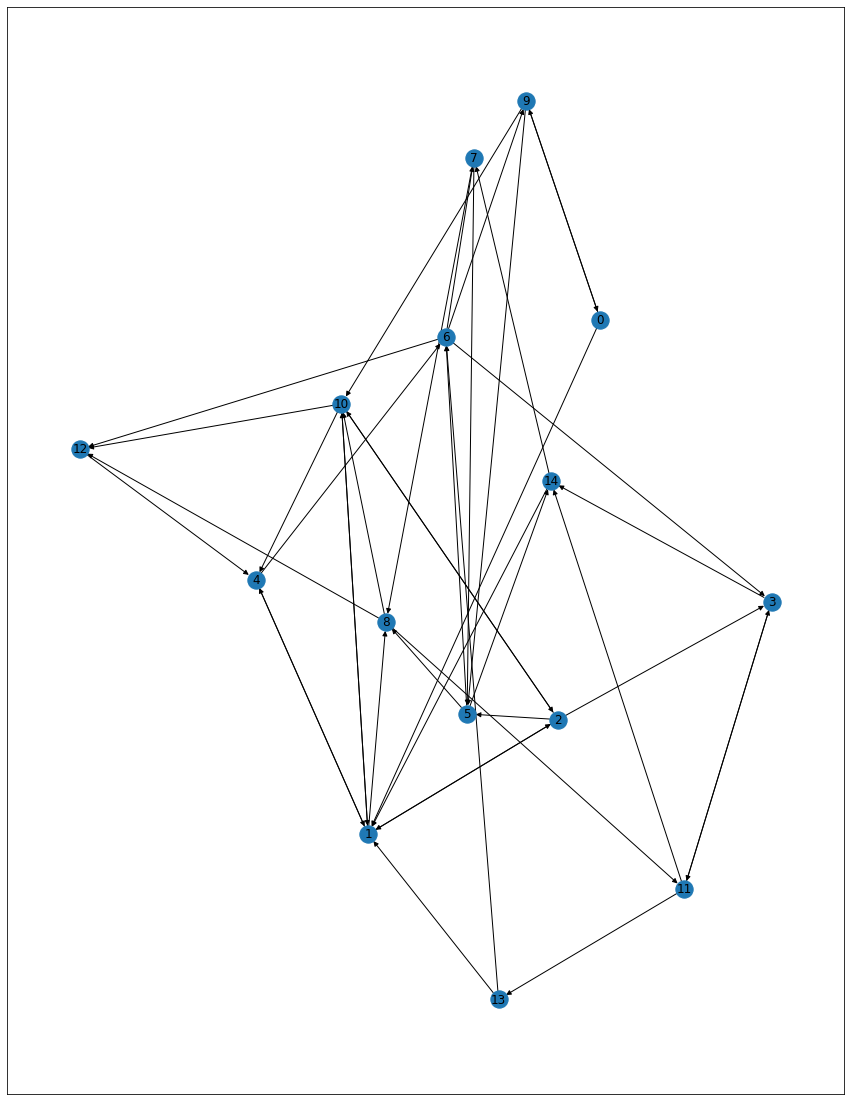

In [697]:
# создаем граф и смотрим на него
V = [i for i in range(15)]
E = {
    0: [1,9],
    1: [2,8,4,10],
    2: [1,3,5,10],
    3: [11,14],
    4: [1,6],
    5: [6,8,14],
    6: [3,7,9,12],
    7: [5,8],
    8: [10,11,12],
    9: [0,5,10],
    10: [1,2,4,12],
    11: [3, 13, 14],
    12: [4],
    13: [1,6],
    14: [1,7],
}
print(V,E)
draw_with_networkx(V, E)

deleting (2,1)
deleting (11,3)
deleting (13,1)
deleting (6,3)
deleting (5,6)
deleting (10,1)
deleting (10,2)
deleting (4,1)
deleting (4,6)
deleting (8,11)
deleting (14,1)
deleting (14,7)
deleting (9,0)


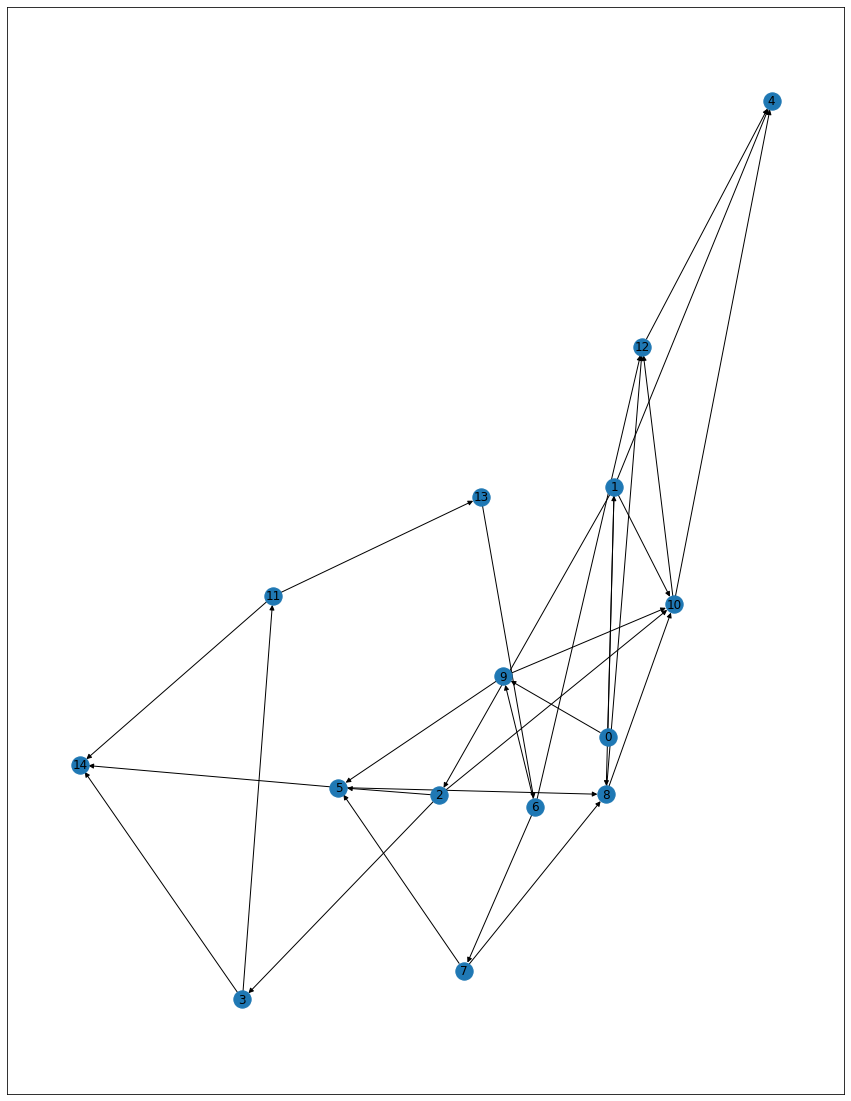

In [698]:
# убираем циклы
E_1 = remove_cycles(V, E)
draw_with_networkx(V, E_1)

Channels =  [[0, 1, 2, 3, 11, 13, 6, 7], [9, 5, 8, 10, 12, 4], [14]]


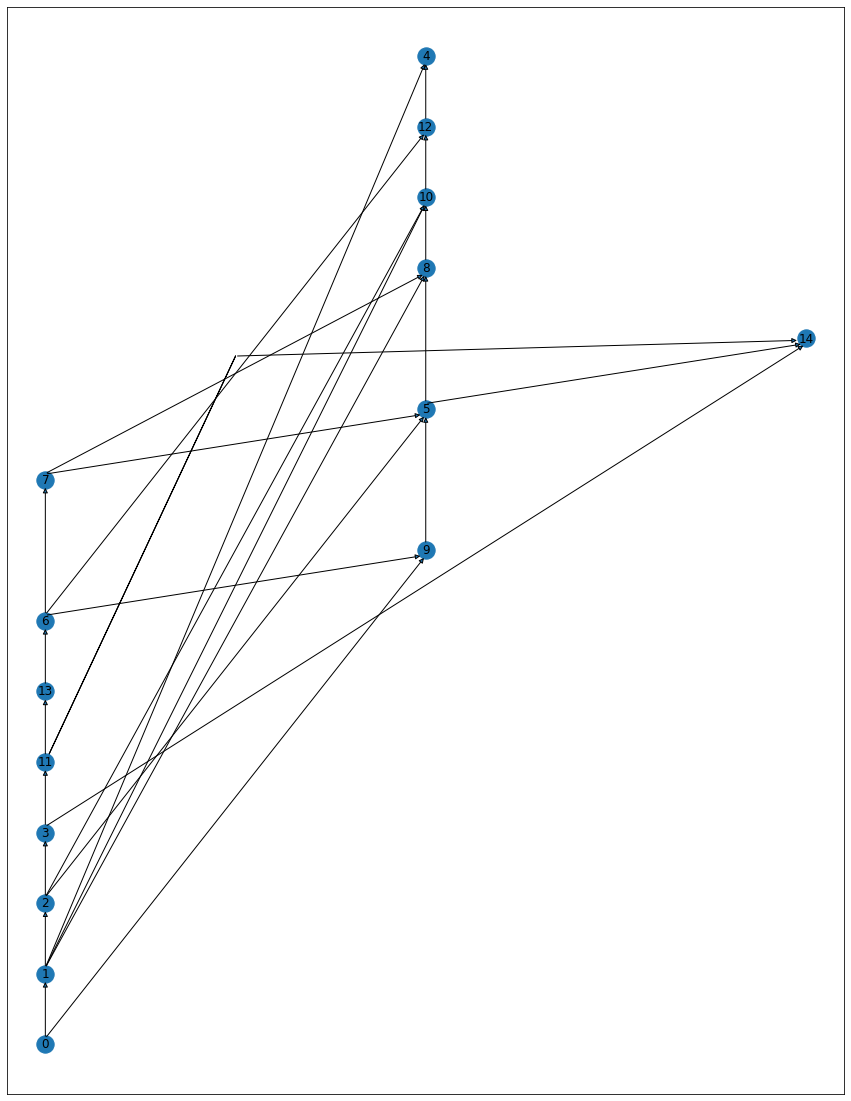

In [699]:
# Здесь вычисляем и рисуем свой граф
# топологическая сортировка
T = topological_sort(V, E_1)
# делим на слои
Vs, Cs = graph_stratification(V, E_1)
# получаем каналы с фиктивными вершинами
Vs1, M1, Cs1 = chain_generation(V, E_1, Vs, Cs)
# удаляем фиктивные вершины
M1, Vs1 = virtual_resolution(V, M1, Vs1, Cs1)
# получаем каналы в удобном виде
channels = get_channels(V, M1, Vs1)
print("Channels = ", channels)
# вспомогательный словарь вешина-> номер канала
path_indices = get_path_indices(channels)
# модифицированный граф
_, H_edges = get_H_graph(V, E_1, channels, path_indices)
# вычисление координат
Xv, Yv, Edges_coords = pch_draw(V, H_edges, channels, path_indices, T)
# рисуем, что получилось
draw_with_networkx_by_coordinates(V, Edges_coords, Xv, Yv)